Epoch 1/50, Training Loss: 0.4092, Validation Loss: 0.0197
Epoch 2/50, Training Loss: 0.0141, Validation Loss: 0.0089
Epoch 3/50, Training Loss: 0.0112, Validation Loss: 0.0089
Epoch 4/50, Training Loss: 0.0108, Validation Loss: 0.0084
Epoch 5/50, Training Loss: 0.0094, Validation Loss: 0.0165
Epoch 6/50, Training Loss: 0.0091, Validation Loss: 0.0098
Epoch 7/50, Training Loss: 0.0088, Validation Loss: 0.0091
Epoch 8/50, Training Loss: 0.0084, Validation Loss: 0.0073
Epoch 9/50, Training Loss: 0.0102, Validation Loss: 0.0087
Epoch 10/50, Training Loss: 0.0072, Validation Loss: 0.0089
Epoch 11/50, Training Loss: 0.0078, Validation Loss: 0.0095
Epoch 12/50, Training Loss: 0.0078, Validation Loss: 0.0224
Epoch 13/50, Training Loss: 0.0080, Validation Loss: 0.0182
Epoch 14/50, Training Loss: 0.0077, Validation Loss: 0.0090
Epoch 15/50, Training Loss: 0.0063, Validation Loss: 0.0091
Epoch 16/50, Training Loss: 0.0060, Validation Loss: 0.0090
Epoch 17/50, Training Loss: 0.0058, Validation Lo

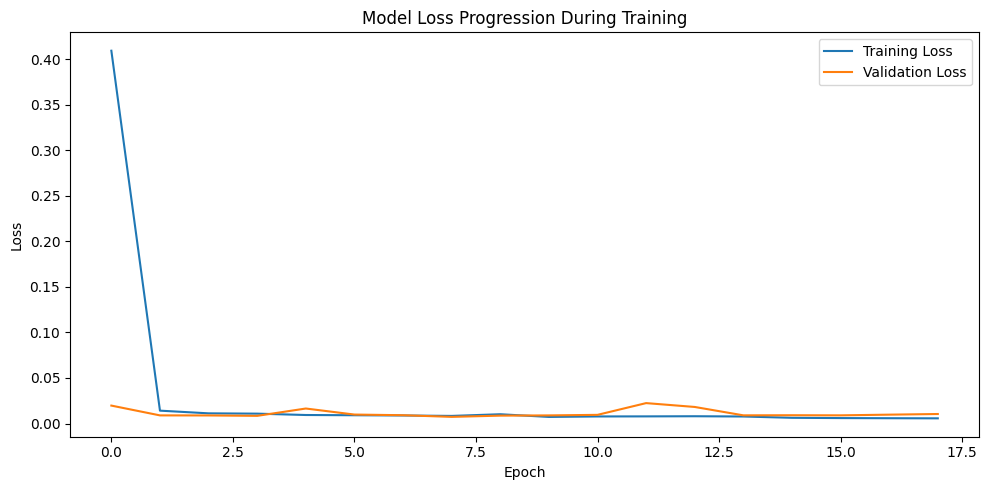

Test Loss: 0.0075
Test MAE: 28664.85
Test MAPE: 0.09


In [ ]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore")

# Load your dataset
df = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU4.csv')

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Split dataset
train_size = int(len(df) * 0.70)
val_size = int(len(df) * 0.15)

train = df.iloc[:train_size].copy()
val = df.iloc[train_size:train_size + val_size].copy()
test = df.iloc[train_size + val_size:].copy()




In [ ]:
# Add time-based features
for dataset in [train, val, test]:
    dataset['month'] = dataset.index.month
    dataset['day_of_week'] = dataset.index.dayofweek
    dataset['month_sin'] = np.sin(2 * np.pi * dataset['month'] / 12)
    dataset['month_cos'] = np.cos(2 * np.pi * dataset['month'] / 12)
    dataset['day_sin'] = np.sin(2 * np.pi * dataset['day_of_week'] / 7)
    dataset['day_cos'] = np.cos(2 * np.pi * dataset['day_of_week'] / 7)


# Add rolling and lag features
def add_rolling_and_lag_features(dataset):
    dataset['rolling_mean_7'] = dataset['sales'].rolling(window=7).mean().shift(1, fill_value=0)
    dataset['rolling_mean_30'] = dataset['sales'].rolling(window=30).mean().shift(1, fill_value=0)
    dataset['lag_7'] = dataset['sales'].shift(7, fill_value=0)
    dataset['lag_30'] = dataset['sales'].shift(30, fill_value=0)
    return dataset

train = add_rolling_and_lag_features(train)
val = add_rolling_and_lag_features(val)
test = add_rolling_and_lag_features(test)

train.fillna(0, inplace=True)
val.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# Scale the sales column
sales_scaler = MinMaxScaler()
train['sales_scaled'] = sales_scaler.fit_transform(train[['sales']].replace([np.inf, -np.inf], 0).astype(float))
val['sales_scaled'] = sales_scaler.transform(val[['sales']].replace([np.inf, -np.inf], 0).astype(float))
test['sales_scaled'] = sales_scaler.transform(test[['sales']].replace([np.inf, -np.inf], 0).astype(float))

# Scale the numerical features
numerical_features = ['rolling_mean_7', 'rolling_mean_30', 'lag_7', 'lag_30']
feature_scaler = MinMaxScaler()
train[numerical_features] = feature_scaler.fit_transform(train[numerical_features].astype(float))
val[numerical_features] = feature_scaler.transform(val[numerical_features].astype(float))
test[numerical_features] = feature_scaler.transform(test[numerical_features].astype(float))

# Select features (only the basic time features and sales-related ones)
features = [
    'sales_scaled', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'rolling_mean_7', 'rolling_mean_30', 'lag_7', 'lag_30'
]

target = 'sales_scaled'
sequence_length = 7

In [ ]:
# Create sequences for LSTM/Transformer models
def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    data_values = data[features].values.astype(float)
    target_values = data[target].values.astype(float)
    for i in range(len(data) - sequence_length):
        X.append(data_values[i:i + sequence_length])
        y.append(target_values[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train, features, target, sequence_length)
X_val, y_val = create_sequences(val, features, target, sequence_length)
X_test, y_test = create_sequences(test, features, target, sequence_length)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Define the Temporal Fusion Transformer (TFT) model
class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GatedResidualNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.gate = nn.Linear(input_size, output_size)

    def forward(self, x):
        x_res = self.fc1(x)
        x_res = self.elu(x_res)
        x_res = self.fc2(x_res)
        x_gate = torch.sigmoid(self.gate(x))
        return x_gate * x_res + (1 - x_gate) * x

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads, num_layers):
        super(TemporalFusionTransformer, self).__init__()
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.variable_selection = GatedResidualNetwork(hidden_size, hidden_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.variable_selection(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x.squeeze()


In [ ]:
# Model parameters
input_size = len(features)
hidden_size = 64
output_size = 1
num_heads = 8
num_layers = 2

In [ ]:
# Instantiate the model
tft_model = TemporalFusionTransformer(input_size, hidden_size, output_size, num_heads, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(tft_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

# Early stopping and device setup
early_stop_patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tft_model.to(device)

In [ ]:
# Training loop
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    tft_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = tft_model(X_batch)
        loss = criterion(outputs, y_batch)
        # Handle NaN loss by resetting gradients and skipping batch
        optimizer.zero_grad()
        if torch.isnan(loss):
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tft_model.parameters(), max_norm=0.5)

        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    tft_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = tft_model(X_batch)
            loss = criterion(outputs, y_batch)
            if torch.isnan(loss):
                continue
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = tft_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered")
            break

if best_model_state:
    tft_model.load_state_dict(best_model_state)


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on test set
tft_model.eval()
test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for i in range(0, len(X_test) - sequence_length, sequence_length):
        X_batch = X_test_tensor[i:i + sequence_length].to(device)
        y_batch = y_test_tensor[i:i + sequence_length].to(device)
        outputs = tft_model(X_batch)
        loss = criterion(outputs, y_batch)
        if torch.isnan(loss):
            continue
        test_loss += loss.item() * X_batch.size(0)

        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

# Inverse scaling for final results
all_predictions_inv = sales_scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
all_targets_inv = sales_scaler.inverse_transform(np.array(all_targets).reshape(-1, 1))

test_mae = mean_absolute_error(all_targets_inv, all_predictions_inv)
print(f"Test MAE: {test_mae:.2f}")

test_mape = mean_absolute_percentage_error(all_targets_inv, all_predictions_inv)
print(f"Test MAPE: {test_mape:.2f}")


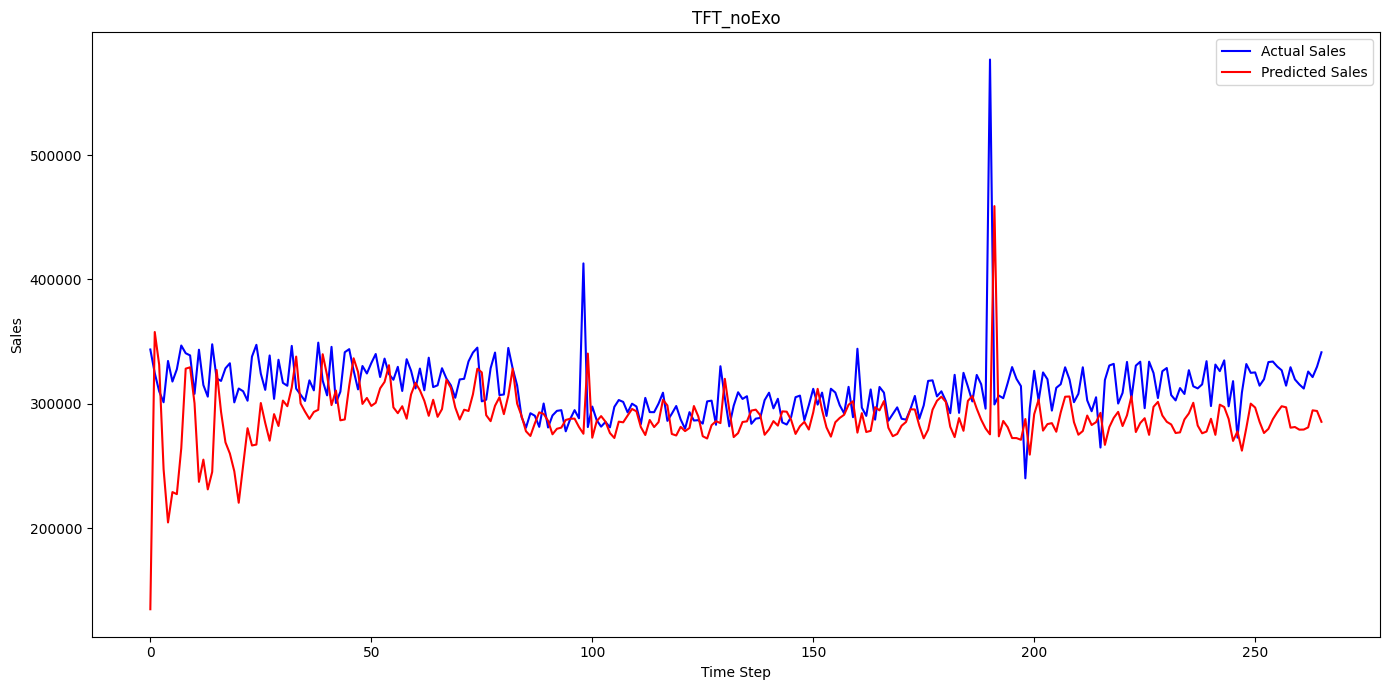

In [15]:
# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(all_targets_inv, label='Actual Sales', color='b')
plt.plot(all_predictions_inv, label='Predicted Sales', color='r')
plt.title('TFT_noExo')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
import sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# Calculate MAE, MAPE, MSE, and R2
mae = mean_absolute_error(all_targets_inv, all_predictions_inv)
mape = mean_absolute_percentage_error(all_targets_inv, all_predictions_inv)
mse = mean_squared_error(all_targets_inv, all_predictions_inv)
r2 = r2_score(all_targets_inv, all_predictions_inv)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

MAE: 28664.8496
MSE: 1795942016.0000
MAPE: 0.0879
R2: -1.8356


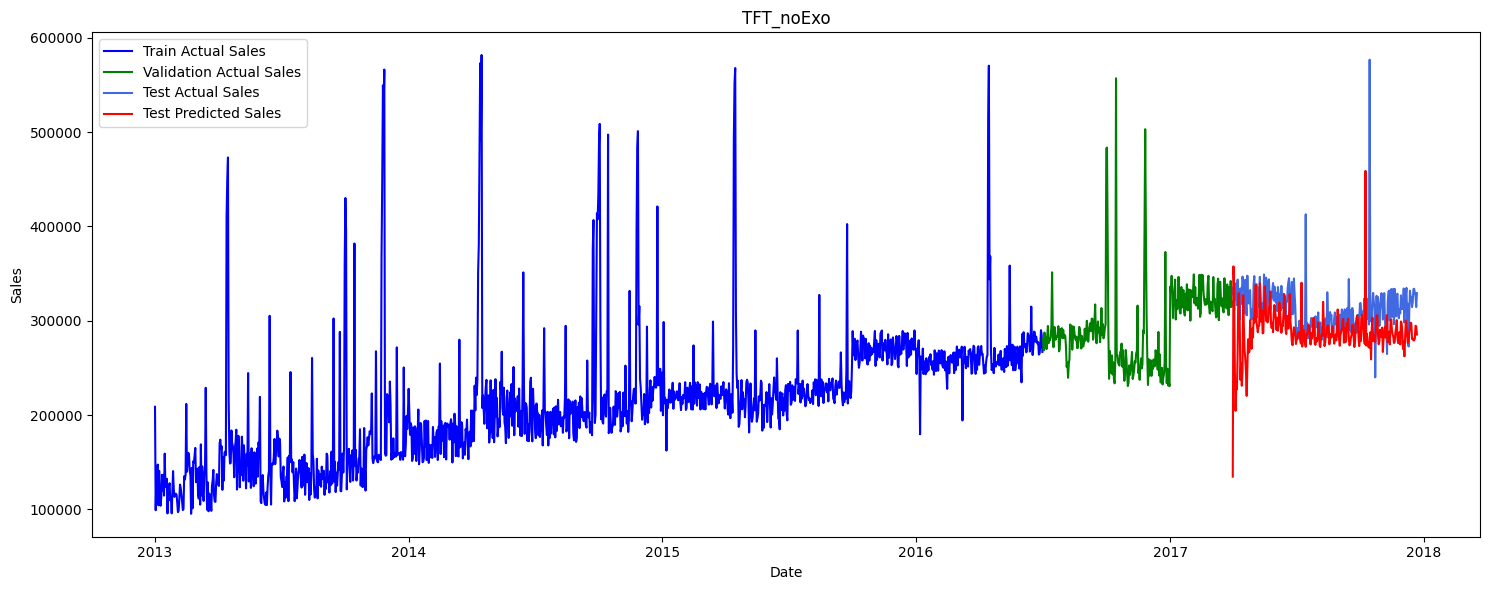

In [17]:
import matplotlib.pyplot as plt

# Plot all data (train, validation, test) along with predictions

# Inverse scale sales data for all sets to visualize them on the original scale
train_sales_inv = sales_scaler.inverse_transform(train['sales_scaled'].values.reshape(-1, 1))
val_sales_inv = sales_scaler.inverse_transform(val['sales_scaled'].values.reshape(-1, 1))
test_sales_inv = sales_scaler.inverse_transform(test['sales_scaled'].values.reshape(-1, 1))

# Define the indices for train, validation, and test for easier plotting
train_idx = train.index
val_idx = val.index
test_idx = test.index[:len(all_predictions_inv)]  # Match predictions length with test set

# Plot the actual and predicted sales data across train, validation, and test
plt.figure(figsize=(15, 6))
plt.plot(train_idx, train_sales_inv, label='Train Actual Sales', color='blue')
plt.plot(val_idx, val_sales_inv, label='Validation Actual Sales', color='green')
plt.plot(test_idx, test_sales_inv[:len(all_predictions_inv)], label='Test Actual Sales', color='#4169E1')
plt.plot(test_idx, all_predictions_inv, label='Test Predicted Sales', color='red')

# Adding title and labels for better visualization
plt.title('TFT_noExo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
